# Advanced Lane Finding

The goals/steps of this project are:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import Packages

In [1]:
#importing some useful packages
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

---
## 1. Camera Calibration
The images for camera calibration are stored in the folder called camera_cal.

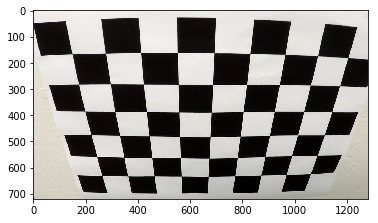

In [2]:
#reading in the calibration image so we can take a look at the chessboard pattern
cal_image = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(cal_image)

Observing the chessboard image, we notice that:

**nx** = 9

**ny** = 6

Where:
 * **nx** is the number of corners in a row and **ny** is the number of corners in a column. Remembering that corners are only points where two black and two white squares intersect. We must count only the inside corners and not the outside corners.

In [3]:
#Number of corners in a row
nx = 9
#Number of corners in a column
ny = 6

We're going to map the coordinates of the corners in this 2D image in an empty array called **"Image points"** to the 3D coordinates of the real undistorted chessboard corners inside **"Object points"**.

The **Object points** will all be the same for all the calibration images, since they will be 3D coordinates (x,y,z) from the top left corner (0,0,0) to the bottom right corner (nx,ny,0) from the real chessboard. Remembering that z-coordinate will always be zero, since we're working with an image on a flat image plane!

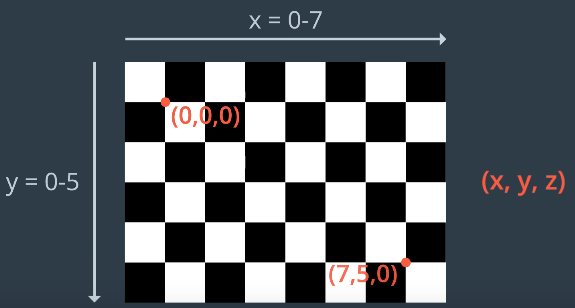

### 1.1 Finding the Chessboard Corners (for an 9x6 board)

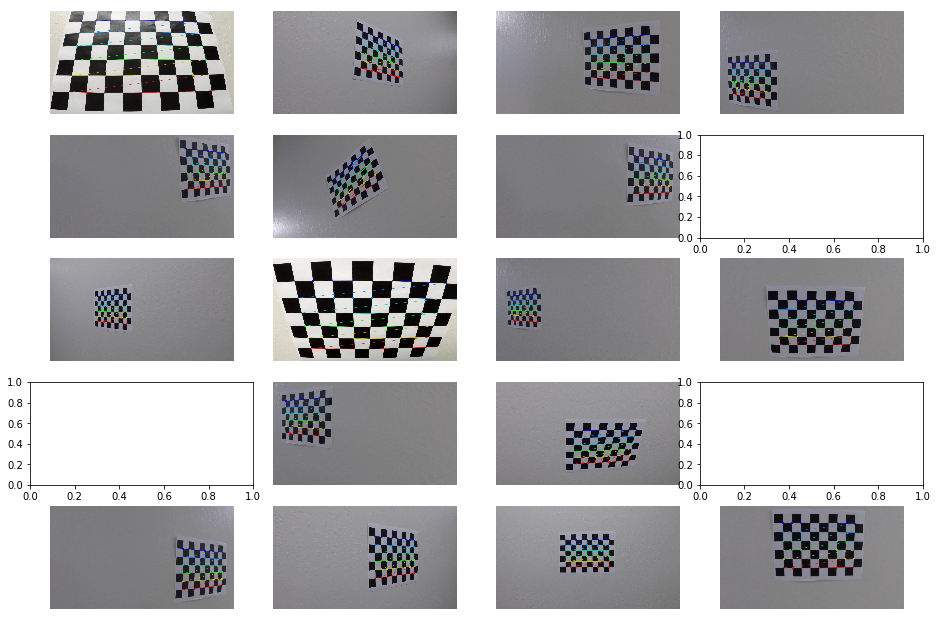

In [4]:
# Glob helps us to read images with a consistent name (like calibration1,calibration2, calibration3...)
cal_images = glob.glob('camera_cal/calibration*.jpg')

# creating empty arrays to store/hold the object points and image points from all the images

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (nx,ny,0)
objp = np.zeros((nx*ny,3), np.float32)
# Because the z-coordinate will always be zero, here we'll only generate the coordinates values of x and y
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

#To iterate through all the images files, detecting corners and appending points to the object and image points arrays:
for i,fname in enumerate(cal_images):
    #read in each image
    img = mpimg.imread(fname)

    # In order to create the image points, we'll need to detect the corners of the real distorded chessboard image
    # Converting the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecting the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If corners are found, add object points and image points
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        #draw and display the corners in the real images
        corners_img = cv2.drawChessboardCorners(img, (nx,ny), corners,ret)
        axs[i].axis('off')
        axs[i].imshow(corners_img)

It is possible to notice that there are some chessboard images that our script couldn't detect the image corners - so they didn't show up on the images printed above. This happened because these images didn't show the complete chessboard patters with 9 row corners and 6 column corners (because the photo was taken too close to it, probably), like the one on the example bellow: 

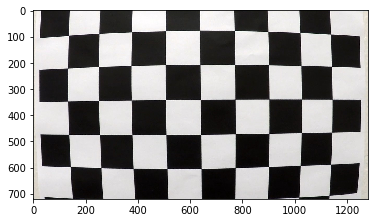

### 1.2 Camera Calibration and Undistorting the test images

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    #Camera calibration, given object points, image points, and the shape of the image:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::], None, None) 
    #Undistorting a test image:
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

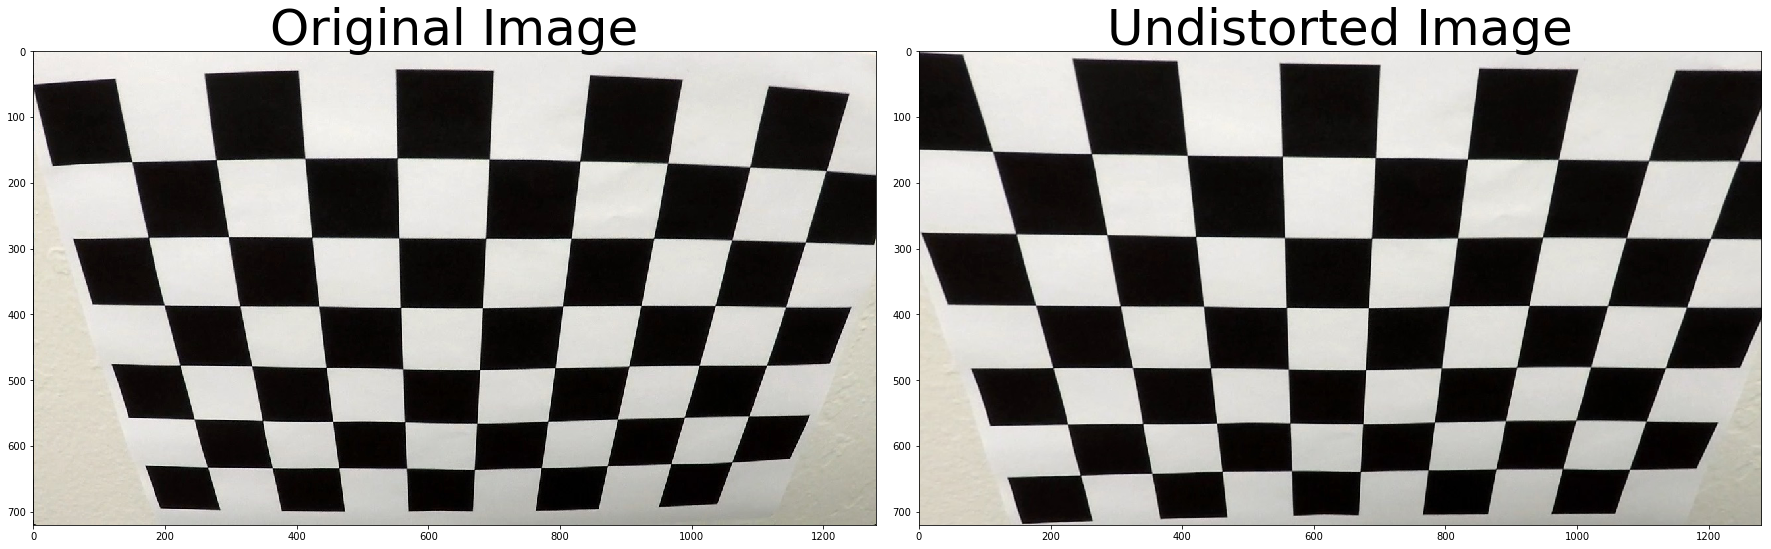

In [6]:
undistorted_image = cal_undistort(cal_image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Looking at the undistorted image, it is important to state that, as the mentor Tejas J explained on this [forum question](https://knowledge.udacity.com/questions/432920), tangential distortion is different from perpesctive diference. *"Some of the calibration images are purposely taken at a different angle by the camera. Tangential distortion occurs when the lens and sensor are not parallel".*

### 1.3 Applying Distortion Correction to raw images

In [7]:
#reading in the test image so we can try undistorting it
test_image = mpimg.imread('test_images/test2.jpg')
undistorted_test_image = cal_undistort(test_image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_test_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

This image is specially good to demonstrate the undistortion, since it is possible to notice the radial distortion correction by looking at the car hood and the tangential distortion by looking at the yellow deer sign. 

---
## 2. Use color transforms, gradients, etc., to create a thresholded binary image

### 2.1. Applying perspective transform

In order to create and apply the perspective transform  (and later measure the lane curvature and get a view that looks more like a map representation), we'll first select four points to define a linear transformation from one perspective to another. Then, we'll use OpenCV functions to calculate the transforms that maps the points in the original image to the warped image with the different perspective.

![image](https://www.scilab.org/sites/default/files/perspective_0.png?itok=3RYNcl0i)

So, to take a better look and see if the selected source points are correctly manually selected, I'll display them on an undistorted test image.

[[ 1280.   720.]]


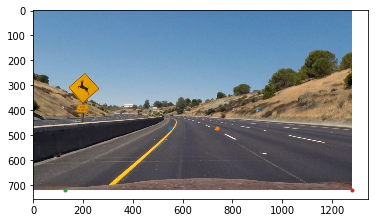

In [43]:
#source image points
img_size = np.float32([(undistorted_test_image.shape[1],undistorted_test_image.shape[0])])
print(img_size)

plt.imshow(undistorted_test_image)
plt.plot(550, 470, '.') #top left
plt.plot(740, 470, '.') #top right
plt.plot(128, 720, '.') #bottom left
plt.plot(1280, 720, '.') #bottom right

In [48]:
#Define perspective transform function
def warp(img):
    
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    
    img_size = (img.shape[1],img.shape[0])
    
    # Four source coordinates
    src = np.float32(
        [[550, 470],
         [740, 470],
         [128, 720],
         [1280, 720]])
    
    # Four desired coordinates
    dst_size = (1280,720)
    dst = np.float32(
        [[0, 0],
         [1280, 0],
         [0, 720],
         [1280, 720]])

    # Compute the perspective transform, M
    # The function getPerspectiveTransform just takes in our four source points and our four destination points and it returns the mapping perspective matrix, which we'll call M
    M = cv2.getPerspectiveTransform(src, dst)

    # Could compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # And now, applying the transform M to the original image to get the warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def inverse_warp(img):
    
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    
    img_size = (img.shape[1],img.shape[0])
    
    # Four source coordinates
    src = np.float32(
        [[550, 470],
         [740, 470],
         [128, 720],
         [1280, 720]])
    
    # Four desired coordinates
    dst_size = (1280,720)
    dst = np.float32(
        [[0, 0],
         [1280, 0],
         [0, 720],
         [1280, 720]])

    # Compute the perspective transform, M
    # The function getPerspectiveTransform just takes in our four source points and our four destination points and it returns the mapping perspective matrix, which we'll call M
    M = cv2.getPerspectiveTransform(src, dst)

    # Could compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # And now, applying the transform M to the original image to get the warped image
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [49]:
%matplotlib inline

# Get perspective transform
warped_im = warp(undistorted_test_image)

#Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

f.tight_layout()
ax1.imshow(undistorted_test_image)
ax1.set_title('Source Image', fontsize=50)
ax2.imshow(warped_im)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2.2.1 Creating thresholded binary image on Grayscale Image

In order to create a binary image to better identify the lane lines, in this project we'll utilize the **thresholding method**, which, in the first place, I'll apply it to a grayscale image (that is better to work with since it has only one Color Channel, unlike color images with three Color Channels R-G-B). This method will basically replace each pixel in an image with a black pixel if the image intensity is less than some fixed constant or a white pixel if the image intensity is greater than that constant.

In [12]:
def sobel_gray(img):
    #Because the sobel function requests the use of a single color channel image, first I converted the images to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Calculating the derivative in the x direction and in the y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    #Because we want to compute the pixel values (of 1 or 0) based on the strength of the x gradient, I calculated the absolute value of the x derivative by using np.absolute
    abs_sobelx = np.absolute(sobelx)
    
    #Converting the absolute value to 8-bit (range from 0 to 255)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #Creating a binary threshold to select pixels based on gradient strength
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

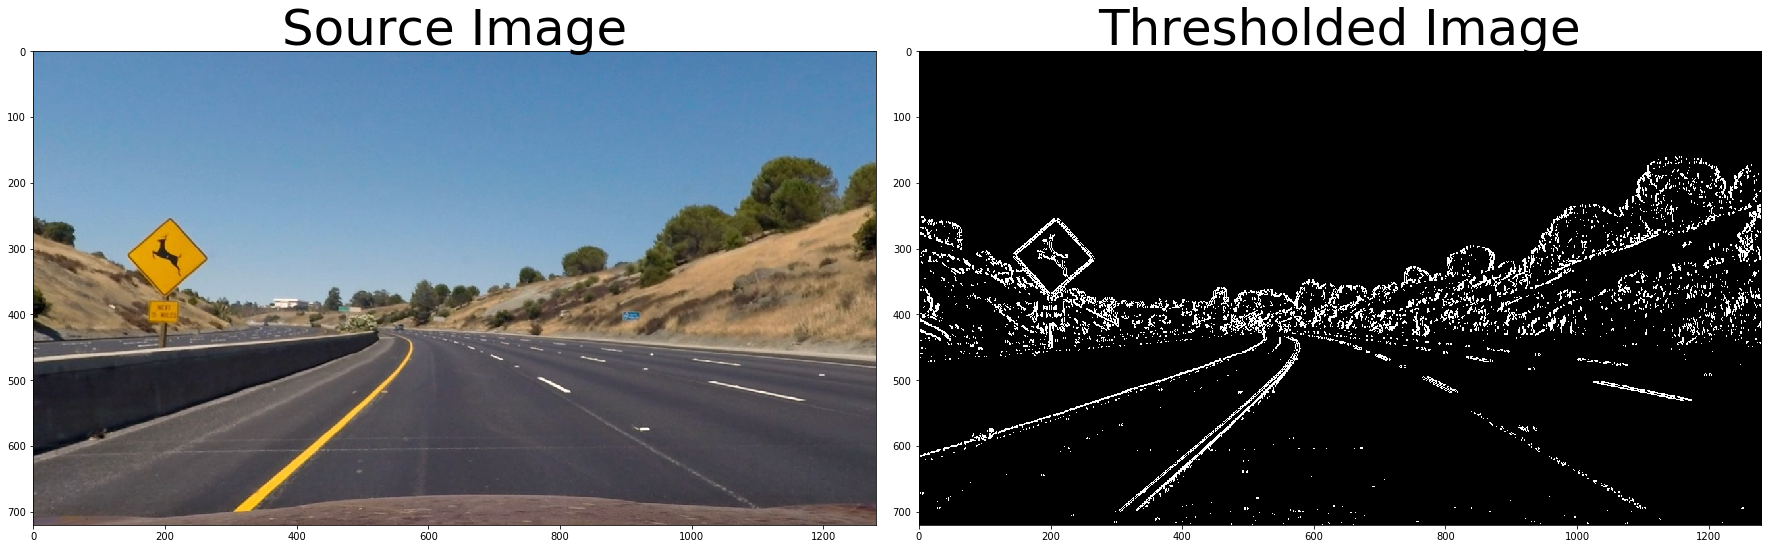

In [13]:
thresh_image = sobel_gray(undistorted_test_image)

#Visualize thresholded image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

f.tight_layout()
ax1.imshow(undistorted_test_image, cmap='gray')
ax1.set_title('Source Image', fontsize=50)
ax2.imshow(thresh_image, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
#Applying the sobel_gray() function on a warped image
thresh_image = sobel_gray(warped_im)

#Visualize thresholded image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

f.tight_layout()
ax1.imshow(undistorted_test_image, cmap='gray')
ax1.set_title('Source Image', fontsize=50)
ax2.imshow(thresh_image, cmap='gray')
ax2.set_title('Thresholded Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

When using a grayscale image, it is possible to see that, when ploting the thresholded lane lines image, we didn't get solid lines. Instead, we got some kind of "double lines" which can confuse our code later on when doing the next steps. Thats why I'll try to use an different color space to see if I'll get some better results.

### 2.2.2 Creating thresholded binary image on HSL Image

When analysing images, not only the **RGB** color space can necessary bethe best choice for all the projects. Two other very commonly used color spaces are the **HSV** (Hue, Saturation and Value) and **HLS** (Hue, Lightness and Saturation) color spaces. According to the Udacity's class notes, *"Most of these different color spaces were either inspired by the human vision system, and/or developed for efficient use in television screen displays and computer graphics."* Here we can see a better 3D representation of each cited color spaces:
![image](https://video.udacity-data.com/topher/2016/November/5834e6ed_screen-shot-2016-11-22-at-4.44.32-pm/screen-shot-2016-11-22-at-4.44.32-pm.png)

In order to achieve a more robust result, here I'll experiment using the **HLS** color space for the lane detection job.


In [15]:
def sobel_HSL(img, s_thresh=(100, 255), sx_thresh=(15, 255)):
    #Because the sobel function requests the use of a single color channel image, I'll now convert to HSL color space and use the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    
    #Calculating the derivative in the x direction and in the y direction
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    #Because we want to compute the pixel values (of 1 or 0) based on the strength of the x gradient, I calculated the absolute value of the x derivative by using np.absolute
    abs_sobelx = np.absolute(sobelx)
    
    #Converting the absolute value to 8-bit (range from 0 to 255)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    #Creating a binary threshold to select pixels based on gradient strength
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

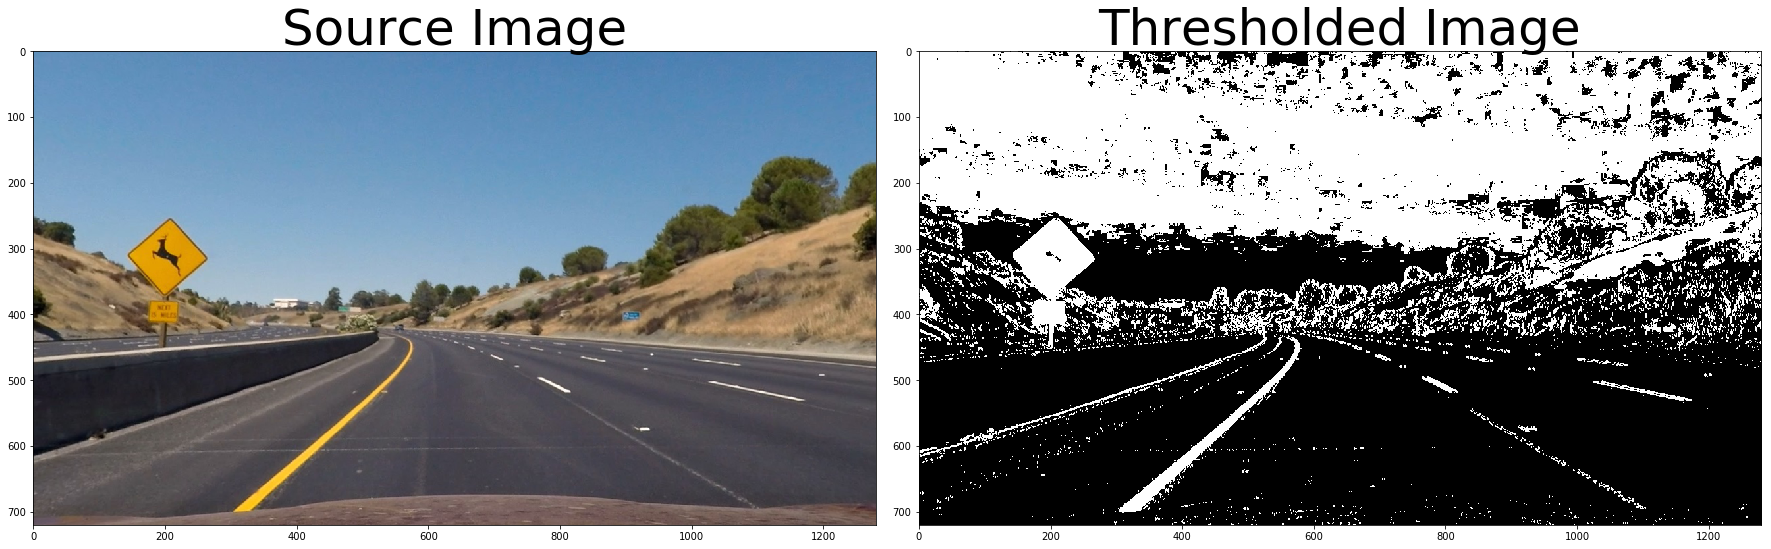

In [16]:
thresh_image = sobel_HSL(undistorted_test_image)

#Visualize thresholded image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

f.tight_layout()
ax1.imshow(undistorted_test_image, cmap='gray')
ax1.set_title('Source Image', fontsize=50)
ax2.imshow(thresh_image, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
#Applying the sobel() function on a warped image
thresh_image = sobel_HSL(warped_im)

#Visualize thresholded image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

f.tight_layout()
ax1.imshow(undistorted_test_image, cmap='gray')
ax1.set_title('Source Image', fontsize=50)
ax2.imshow(thresh_image, cmap='gray')
ax2.set_title('Thresholded Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Got a decent result, specially when comparing to the grayscale thresholded image.

## 3. Puting all the image preprocesing techniques together on all Test Images

In [18]:
def preprocess(img):
    
    #Undistorting 
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    #Perspective Transform 
    warped = warp(undistorted)
    
    #Threshold 
    thresholded = sobel_HSL(warped)
    
    return thresholded

In [19]:
# Glob helps us to read images with a consistent name (like test_image1,test_image2, test_image3...)
images = glob.glob('./test_images/*.jpg')

# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin = preprocess(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

One important observation is that, when applying the transform to new images, the test of whether or not you got the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved. Also, it is important to notice that the thresholded images were not so great on the image where we have some shadows projected by the trees on the road... Thats one point to try to improve on next projects.

---

## 4. Detecting lane pixels and fitting them to find the lane boundary and determining the curvature of the lane and vehicle position with respect to center

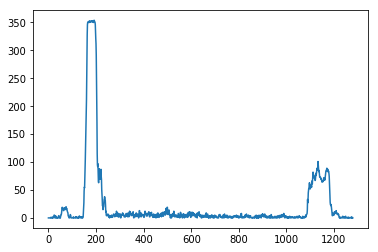

In [54]:
hist = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
plt.plot(hist)

Dividing the histogram in two halfes, we can separate and determine the left peak as the starting point of te left line and the right peak as the starting point of the right lane.

In [55]:
def histogram(img):
    # Take a histogram of the bottom half of the image
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    return hist

# Create an output image to draw on and visualize the result
out_img = np.dstack((img_bin, img_bin, img_bin))*255
#plt.imshow(out_img)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(hist.shape[0]//2)
leftx_base = np.argmax(hist[:midpoint])
rightx_base = np.argmax(hist[midpoint:]) + midpoint

Time to set some hyperparameters related to the sliding windows, where:

**nwindows** = Number of Sliding Windows

**margin** = Width of the windows +/- margin

**minpix** = Minimum number of pixels found to recenter window

In [56]:
# HYPERPARAMETERS
nwindows = 9
margin = 100
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(img_bin.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

Following the Udacity's *Sliding Window* Lesson, in order to iterate through nwindows to track curvature, I used the following pipeline:

1. Loop through each window in <mark>nwindows</mark>

2. Find the boundaries of our current window. This is based on a combination of the current window's starting point (<mark>leftx_current </mark>and <mark>rightx_current</mark>), as well as the margin you set in the hyperparameters.

3. Use <mark>cv2.rectangle</mark> to draw these window boundaries onto our visualization image <mark>out_img</mark>. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.

4. Now that we know the boundaries of our window, find out which activated pixels from <mark>nonzeroy</mark> and <mark>nonzerox</mark> above actually fall into the window.

5. Append these to our lists <mark>left_lane_inds</mark> and <mark>right_lane_inds</mark>.

6. If the number of pixels you found in Step 4 are greater than your hyperparameter minpix, re-center our window (i.e. <mark>leftx_current</mark> or <mark>rightx_current</mark>) based on the mean position of these pixels.

7. After finding the pixels belonging to each line through this method, it is necessary to fit a polynomial to the line.


In [57]:
def find_lane_pixels(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img_bin)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

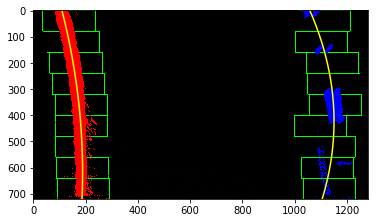

In [58]:
out_img = fit_polynomial(img_bin)

plt.imshow(out_img)

---
The code above has turned out to be relatively efficient on static images, but, when working directly with videos, using the full algorithm on every frame is not that efficient. Once you don't need to do a *"blind search"* again because lane lines don't necessarily move a lot from frame to frame, we can **search in a margin around the previous lane line position**. *So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame*.

**Note**: In the image above, specifically when observing the windows in the left lane, it is possible no notice that some windows seems to be open/incomplete, but this does not mean that it is wrong! According to the instructor Jay T (where he explained on this [knowledge question](https://knowledge.udacity.com/questions/239078)), *"Matplotlib draws px-wide lines, and due to the resizing that happened when ploting the curves, some lines didn't display properly"*.

### 4.1. Putting it all together:

In [59]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    hist = histogram(img)
    # find peaks of left and right halves
    midpoint = int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        
#        if len(good_right_inds) > minpix:        
#            rightx_current = np.int(np.mean([leftx_current +900, np.mean(nonzerox[good_right_inds])]))
#        elif len(good_left_inds) > minpix:
#            rightx_current = np.int(np.mean([np.mean(nonzerox[good_left_inds]) +900, rightx_current]))
#        if len(good_left_inds) > minpix:
#            leftx_current = np.int(np.mean([rightx_current -900, np.mean(nonzerox[good_left_inds])]))
#        elif len(good_right_inds) > minpix:
#            leftx_current = np.int(np.mean([np.mean(nonzerox[good_right_inds]) -900, leftx_current]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def measure_curvature(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (249,142,29))
    inverse_warped = inverse_warp(color_img)
    inverse_warped = cv2.addWeighted(img, 1, inverse_warped, 0.7, 0)
    return inverse_warped

### 4.2. Visualising the results!

(2, 720)
(1157.2822721380064, 327.85030655465687, 0.57360571472361976)


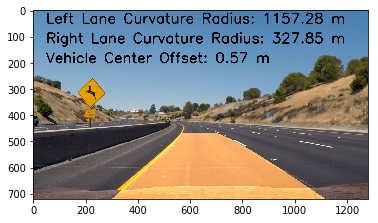

In [71]:
out_img, curves, lanes, ploty = sliding_window(img_bin)
print(np.asarray(curves).shape)
left_curverad, right_curverad, center=measure_curvature(img_bin, curves[0],curves[1])
print(curverad)

img_ = draw_lanes(img, curves[0], curves[1])

font = cv2.FONT_HERSHEY_SIMPLEX # To chose other fonts, press TAB after the ‘FONT_’, and it will show all the fonts supported by cv2
cv2.putText(img_, text='Left Lane Curvature Radius: {:.2f} m'.format(left_curverad), org=(50,50), fontFace=font, fontScale=1.8, color=(0,0,0), thickness=3, lineType=cv2.LINE_AA)  # org is the bottom left corner of our text box
cv2.putText(img_, text='Right Lane Curvature Radius: {:.2f} m'.format(right_curverad), org=(50,125), fontFace=font, fontScale=1.8, color=(0,0,0), thickness=3, lineType=cv2.LINE_AA)  # org is the bottom left corner of our text box
cv2.putText(img_, text='Vehicle Center Offset: {:.2f} m'.format(center), org=(50,200), fontFace=font, fontScale=1.8, color=(0,0,0), thickness=3, lineType=cv2.LINE_AA)  # org is the bottom left corner of our text box

plt.imshow(img_, cmap='hsv')

In [76]:
def final_processing(img):
    img_bin = preprocess(img)
    out_img, curves, lanes, ploty = sliding_window(img_bin)
    left_curverad, right_curverad, center=measure_curvature(img_bin, curves[0],curves[1])
    
    final_img = draw_lanes(img, curves[0], curves[1])
    cv2.putText(final_img, text='Left Lane Curvature Radius: {:.2f} m'.format(left_curverad), org=(50,50), fontFace=font, fontScale=1.8, color=(0,0,0), thickness=3, lineType=cv2.LINE_AA)  # org is the bottom left corner of our text box
    cv2.putText(final_img, text='Right Lane Curvature Radius: {:.2f} m'.format(right_curverad), org=(50,125), fontFace=font, fontScale=1.8, color=(0,0,0), thickness=3, lineType=cv2.LINE_AA)  # org is the bottom left corner of our text box
    cv2.putText(final_img, text='Vehicle Center Offset: {:.2f} m'.format(center), org=(50,200), fontFace=font, fontScale=1.8, color=(0,0,0), thickness=3, lineType=cv2.LINE_AA)  # org is the bottom left corner of our text box

    return final_img

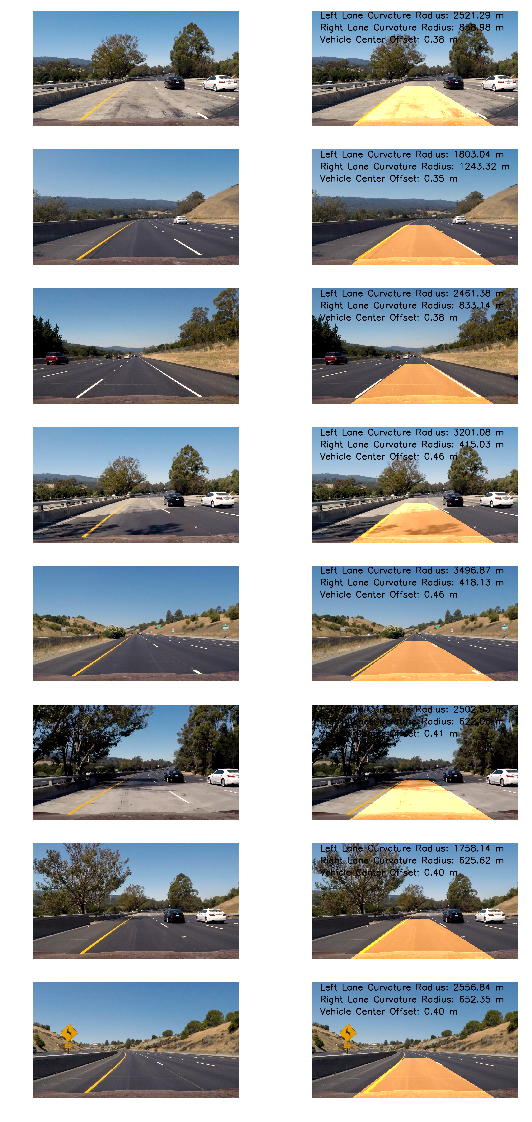

In [77]:
# Glob helps us to read images with a consistent name (like test_image1,test_image2, test_image3...)
images = glob.glob('./test_images/*.jpg')

# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    final_img = final_processing(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(final_img, cmap='hsv')
    axs[i].axis('off')
    i += 1

## 5. Processing the video frame images

In [78]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip

myclip = VideoFileClip('project_video.mp4')#.subclip(40,43)
output_vid = 'output.mp4'
clip = myclip.fl_image(final_processing)
clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [32:22<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

